# Neural Style Transfer Part 2, Reproducing Style

This example shows how we can try to reproduce artistic style of an image using a [Gramm matrix](https://en.wikipedia.org/wiki/Gram_matrix).

In [1]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
tf.compat.v1.disable_eager_execution()

from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

from scipy.optimize import fmin_l_bfgs_b

In [2]:
def gram_matrix(img):
    # Image shape is [h x c], where c = number of channels
    # This needs to be converted to [c, h*w]
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))

    # Calcuate the Gram matrix, G = XX^T / N
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return G

def style_loss(y, t): 
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

def minimize(x, fn, epochs, batch_shape):
    '''Search for the solution that minimizes the given function fn
    
    x0 : starting value
    fn : function which is to be minimized
         f, g = func(x, args)
             f : is the value of the function at x
             g : is the gradient of the function at x
    epochs : number of iterations
    batch_shape : shape of the tensor [b, h, w, c], whre b = batch size and c = nr channels
    '''

    losses = []
    images = []
    
    # Search for the solution
    print('Minimizing the function')
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(
                    func = fn,
                    args = batch_shape,
                    x0 = x,
                    maxfun = 20)
        
        # Store the solution
        x = np.clip(x, -127, 127)
        x_ = np.copy(x)
        x_ = scale_img(unpreprocess(x_.reshape(*batch_shape)))
        images.append(x_[0])
        
        print("iter=%s, loss=%s" % (i, l))
        losses.append(l)

    plt.plot(losses)
    plt.title('Loss per iteration')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()

    return images

def VGG16_with_AvgPool(shape):
    '''Loads a pre-trained VGG16 and replaces max pooling by average pooling.
    
    Max pooling is too aggressive at throwing away information, whereas average-pooling
    retains more of the original information.
    '''
    
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

    i = vgg.input
    x = i
    
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            x = AveragePooling2D()(x)
        else:
            x = layer(x)

    return Model(i, x)


def VGG16_AvgPool_CutOff(shape, num_convs):
    '''Loads a pre-trained VGG16 with average-pooling, and limits the number of
    convolutional layers.
    '''
    
    if num_convs < 1 or num_convs > 13:
        print('Number of convolutions must be in the range [1, 13]')
        return None
    
    vgg = VGG16_with_AvgPool(shape)
    
    n = 0
    output = None
    
    for layer in vgg.layers:
        if layer.__class__ == Conv2D:
            n += 1
        if n >= num_convs:
            output = layer.output
            break
            
    return Model(vgg.input, output)

def unpreprocess(img):
    '''Removes VGG16 preprocessing from the given image.
    '''
    
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    
    return img

def scale_img(x):
    '''Scales the image between [0...1].
    '''
    
    x = x - x.min()
    x = x / x.max()
    
    return x

In [3]:
# Path to a test image
img_path = './large_files/van_gogh.jpeg'

# Load the test image, add a dimension so that it has shape
# [B H W C] where B is the batch size and C is number of channels
img = image.load_img(img_path)

x = image.img_to_array(img)
print(f'Image shape before expanding dimensions: {x.shape}')
x = np.expand_dims(x, axis=0)
print(f'Image shape after expanding dimensions: {x.shape}')
x = preprocess_input(x)

batch_shape = x.shape
shape = x.shape[1:]

print(f'Shape with the batch size included: {batch_shape}')
print(f'Shape without the batch size: {shape}')

Image shape before expanding dimensions: (252, 200, 3)
Image shape after expanding dimensions: (1, 252, 200, 3)
Shape with the batch size included: (1, 252, 200, 3)
Shape without the batch size: (252, 200, 3)


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 252, 200, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 252, 200, 3), dtype=float32)


/home/jarno/miniconda3/envs/tensorflow2-gpu/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Minimizing the function
iter=0, loss=6527.90625
iter=1, loss=307.10772705078125
iter=2, loss=63.14147186279297
iter=3, loss=33.396705627441406
iter=4, loss=23.387720108032227
iter=5, loss=17.650794982910156
iter=6, loss=13.904558181762695
iter=7, loss=11.954832077026367
iter=8, loss=10.69544792175293
iter=9, loss=9.702712059020996


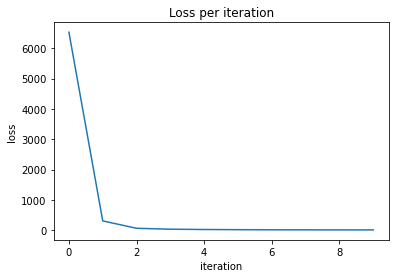

In [4]:
# Create a VGG model with average pool instead of max pooling
vgg = VGG16_with_AvgPool(shape)

# Note: need to select output at index 1, since outputs at
# index 0 correspond to the original vgg with maxpool
symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')
]

# pick the earlier layers for
# a more "localized" representation
# this is opposed to the content model
# where the later layers represent a more "global" structure
# symbolic_conv_outputs = symbolic_conv_outputs[:2]

# Create a model that has an output after each layer
multi_output_model = Model(vgg.input, symbolic_conv_outputs)

# Store the predictions at each layer, for the given input x, and store the results in a list
style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

# Calculate the total sum of the style loss
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
    # gram_matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])

grads = K.gradients(loss, multi_output_model.input)

get_loss_and_grads = K.function(
    inputs = [multi_output_model.input],
    outputs = [loss] + grads
)

def get_loss_and_grads_wrapper(x_vec, *batch_shape):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

# Search solution that minimizes the style loss
x0 = np.random.randn(np.prod(batch_shape))
images = minimize(x0, get_loss_and_grads_wrapper, 10, batch_shape)

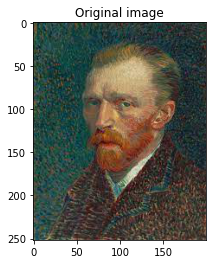

In [5]:
plt.imshow(img)
plt.title('Original image')
plt.show()

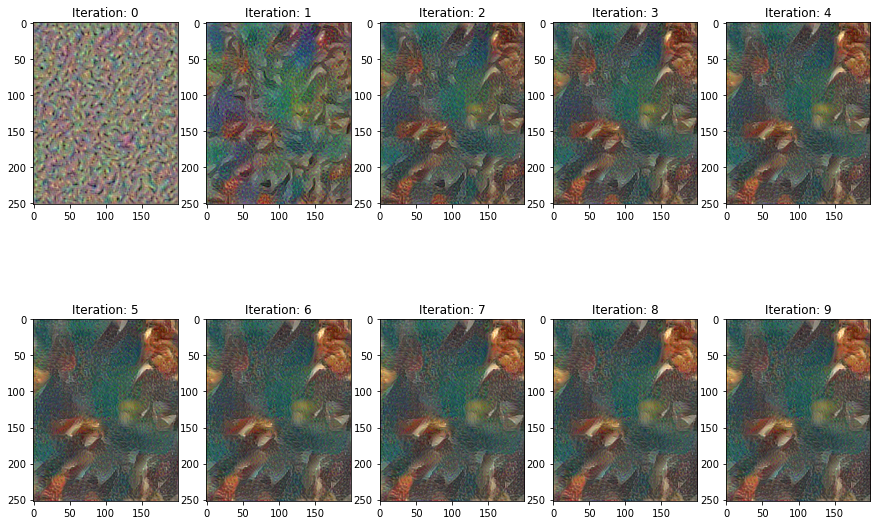

In [6]:
# Show the solution after each iteration
cols = 5
rows = math.ceil(len(images)/cols)
fig, axis = plt.subplots(rows, cols, figsize=(15, 10))

for index in range(len(images)):
    i = math.floor(index/cols)
    j = index % cols
    axis[i, j].imshow(images[index])
    axis[i, j].set_title(f'Iteration: {index}')